# 11: Hail Average Magnitude Forecast | Region: U.S. Northeast
---

## 1. Imports

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from datetime import datetime

pd.set_option('display.max_columns', None)

---
## 2. Loading Data

In [16]:
all_storms = pd.read_csv('../data/all_storms_dt_damage_clean.csv')

/Applications/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


---
## 3. Organizing Data

### 3.1. Dropping Columns

In [17]:
all_storms = all_storms[['state', 'region', 'event_type', 'begin_date_time', 'magnitude']]

In [18]:
all_storms

,state,region,event_type,begin_date_time,magnitude
0,Oklahoma,South,Tornado,1950-04-28 14:45:00,0.0
1,Texas,South,Tornado,1950-06-19 20:40:00,0.0
2,Indiana,Midwest,Tornado,1950-07-19 14:30:00,0.0
3,Indiana,Midwest,Tornado,1950-07-19 17:45:00,0.0
4,Colorado,West,Tornado,1950-07-22 15:07:00,0.0
...,...,...,...,...,...
1740591,Arkansas,South,Winter Storm,2022-02-02 18:45:00,NaN
1740592,Arkansas,South,Winter Weather,2022-02-03 02:50:00,NaN
1740593,Arkansas,South,Winter Storm,2022-02-03 01:00:00,NaN
1740594,Massachusetts,Northeast,Heavy Snow,2022-02-25 00:00:00,NaN


In [19]:
# Casting the begin_date_time to a datetime dtype
all_storms['begin_date_time'] = pd.to_datetime(all_storms['begin_date_time'])

# Setting begin_date_time as the index
all_storms.set_index('begin_date_time', inplace=True)

# Sorting the index
all_storms.sort_index(inplace=True)

In [20]:
# Dropping all rows with a missing value in the magnitude column

all_storms = all_storms.dropna(subset=['magnitude'])

### 3.2. Subsetting to Hail in the Northeast (2000-2022)

In [21]:
hail = all_storms[all_storms['event_type'] == 'Hail']

hail = hail[hail['region'] == 'Northeast']

hail = hail[hail.index > '2000']

In [22]:
hail

,state,region,event_type,magnitude
begin_date_time,,,,
2000-03-09 12:45:00,New York,Northeast,Hail,0.75
2000-03-09 13:30:00,New York,Northeast,Hail,0.01
2000-03-11 19:10:00,New Jersey,Northeast,Hail,0.88
2000-03-25 16:45:00,Pennsylvania,Northeast,Hail,0.75
2000-03-25 17:02:00,Pennsylvania,Northeast,Hail,0.75
...,...,...,...,...
2021-11-13 14:40:00,New York,Northeast,Hail,0.75
2021-11-13 14:50:00,New York,Northeast,Hail,1.50
2022-01-17 01:52:00,New Jersey,Northeast,Hail,0.88


### 3.3. Resampling to Quarterly Averages

In [23]:
# Helper plotting function

def plot_series(df, cols=None, title='Title', xlab=None, ylab=None, steps=1):
   
    plt.figure(figsize=(10,6))
    
    for col in cols:
        plt.plot(df[col])

    plt.title(title, fontsize=14)
    plt.xlabel(xlab, fontsize=12)
    plt.ylabel(ylab, fontsize=12)
    
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12);

In [24]:
# Resampling to quarterly averages
hail = hail.resample('Q').mean()

# Renaming the column to 'avg_mag'
hail = hail.rename(columns={'magnitude': 'avg_mag'})

In [25]:
# Checking for null values as a result of the resampling

hail.isnull().sum()

avg_mag    11
dtype: int64

In [26]:
# Using the interpolate function to fill in the missing values with the mean of the previous value and the next value

hail = hail.interpolate()

In [27]:
hail

,avg_mag
begin_date_time,
2000-03-31,0.628000
2000-06-30,0.970376
2000-09-30,0.968381
2000-12-31,1.102727
2001-03-31,1.061011
...,...
2021-03-31,0.750000
2021-06-30,1.000672
2021-09-30,1.053081


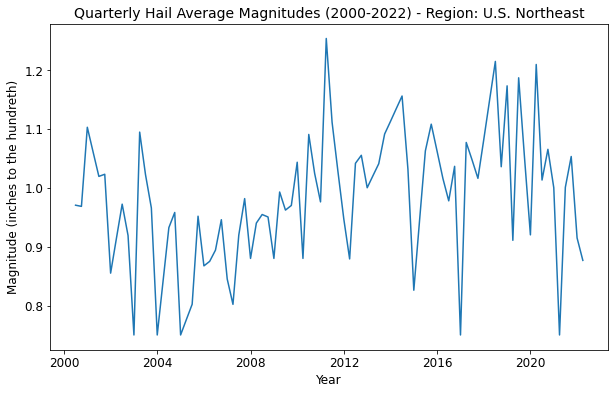

In [56]:
# Quarterly Hail Average Magnitudes (2000-2022) - Region: U.S. Northeast

plot_series(hail, ['avg_mag'], title='Quarterly Hail Average Magnitudes (2000-2022) - Region: U.S. Northeast', xlab='Year', ylab='Magnitude (inches to the hundreth)', steps=4)

---
## 4. Trends

### 4.1. Seasonality

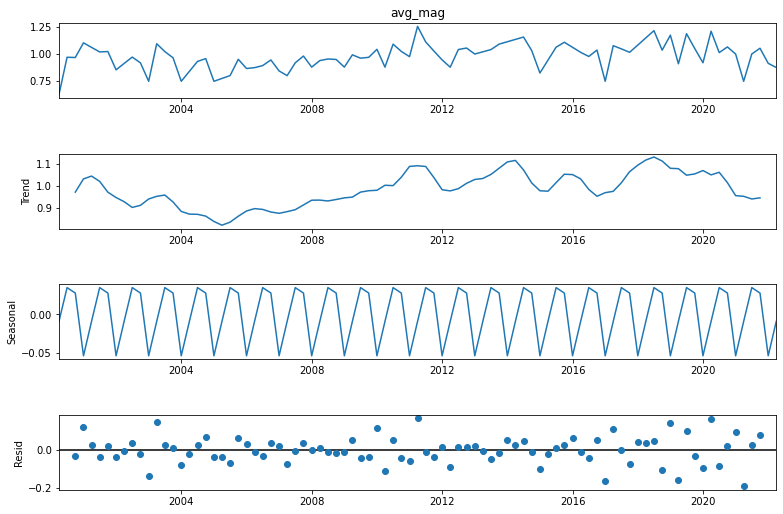

In [29]:
decomp = seasonal_decompose(hail['avg_mag'])

decomp.plot();
fig = plt.gcf()
fig.set_size_inches(12, 8)

In the trend component, we see a bit of fluctuation but in general, the averages have increased over time.

In the seasonal component, we see that there appears to be some seasonality detected. But this seasonal view can sometimes be misleading, so I'll need to run some additional diagnostics.

In the resid component, we see that there's quite a bit of variability that can not be explained by the model.

### 4.2. Autocorrelation

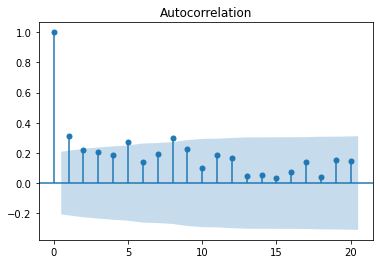

In [30]:
plot_acf(hail['avg_mag']);

For trend, only the 1st, 5th and 8th lags extend beyond the blue region, which represents a 95% confidence interval, meaning that there do not seem to be any string trends in the data.

For seasonality, the fluctuations do not seem to occur with a fixed and known frequency and therefore, indicates that there is likely no seasonality present in the data.

For lags, it seems that using the first will be useful to include in the model, as it extends beyond the blue region. While there are later lags that also extend beyond the blue region, there are lags in between them that do not, thereby making them lags that are not likely to improve model performance.

### 4.3. Partial Autocorrelation

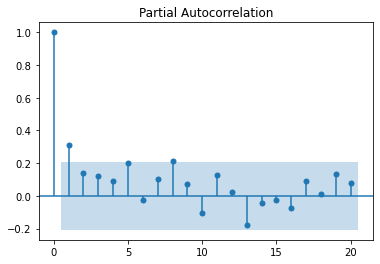

In [31]:
plot_pacf(hail['avg_mag']);

For seasonality, the fluctuations still do not seem to occur with a fixed and known frequency and therefore, confirms that there is no seasonality present.

For lags, the first lag seems like it'll be useful to include in the model.

### 4.4. Stationarity

In [32]:
# Dickey-Fuller Stationarity Test


adfuller(hail['avg_mag'])

(-2.168296189176009,
 0.2179526170091547,
 4,
 84,
 {'1%': -3.510711795769895,
  '5%': -2.8966159448223734,
  '10%': -2.5854823866213152},
 -123.51497032806876)

The first 2 statistics of the test results tell me that the data is not stationary.

The 'test statistic', the first statistic, needs to be less than the critical values, which are the 1%, 5% and 10% values, and it is not. The p-value, the second statistic, needs to be less than the alpha of 0.05, and it is not. As a result, I'll need to difference the data.

### 4.5. Differencing

In [33]:
# Differencing the data

hail['first_diff'] = hail['avg_mag'].diff()

In [34]:
# Dropping any null values as a result of the differencing

hail.dropna(inplace=True)

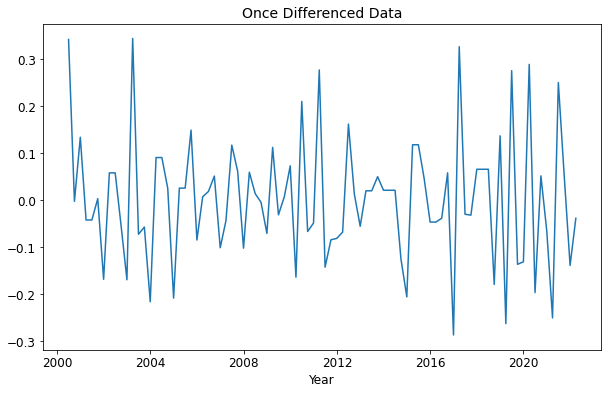

In [35]:
plot_series(hail, ['first_diff'], title='Once Differenced Data', xlab='Year', steps=4)

In [37]:
# Checking for the stationarity of the once differenced data

adfuller(hail['first_diff'])

(-8.30325105934421,
 3.9659084389067373e-13,
 3,
 84,
 {'1%': -3.510711795769895,
  '5%': -2.8966159448223734,
  '10%': -2.5854823866213152},
 -119.64351628261872)

The test statistic is now less than the critical values and the p-value is less than the alpha of 0.05. The data is now stationary and can be modeled on with ARIMA.

---
## 5. ARIMA Time Series Modeling

### 5.1. Train-Test Split

In [39]:
y_train, y_test = train_test_split(hail['first_diff'], test_size=0.1, shuffle=False)

### 5.2. GridSearch for best AIC, p & q

Because I needed to difference the data once, I know that the d parameter for the ARIMA model is 1. Given that, I'll run a GridSearch for the most optimal p & q.

In [26]:
best_aic = 1_000_000_000
best_p = 0
best_q = 0

for p in range(5):
    for q in range(5):

        try:
            
            arima = ARIMA(endog = y_train.astype(float).dropna(),
                         order=(p, 1, q))
            
            model = arima.fit(method_kwargs={"warn_convergence": False})

            print(f'The AIC for ARIMA({p},1,{q}) is: {model.aic}')

            if model.aic < best_aic:
                best_aic = model.aic
                best_p = p
                best_q = q

        except Exception as e:
            print(e)
print()
print()
print('MODEL FINISHED!')
print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p},1,{best_q}).')
print(f'This model has an AIC of {best_aic}.')

The AIC for ARIMA(0,1,0) is: -20.683141071355973
The AIC for ARIMA(0,1,1) is: -89.65398522812092
The AIC for ARIMA(0,1,2) is: -111.3123300227139


/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(0,1,3) is: -110.84136453069117
The AIC for ARIMA(0,1,4) is: -109.19687185725147
The AIC for ARIMA(1,1,0) is: -57.38511562944923
The AIC for ARIMA(1,1,1) is: -99.32516850724411
The AIC for ARIMA(1,1,2) is: -111.01140307863004
The AIC for ARIMA(1,1,3) is: -107.9320198011607
The AIC for ARIMA(1,1,4) is: -107.09968413011987
The AIC for ARIMA(2,1,0) is: -68.29765694615496
The AIC for ARIMA(2,1,1) is: -100.5833076546206
The AIC for ARIMA(2,1,2) is: -96.17658444906002
The AIC for ARIMA(2,1,3) is: -107.27645761186379


/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


The AIC for ARIMA(2,1,4) is: -104.11286609350952
The AIC for ARIMA(3,1,0) is: -77.52200855274997
The AIC for ARIMA(3,1,1) is: -103.04366866600843
The AIC for ARIMA(3,1,2) is: -102.99768539820482
The AIC for ARIMA(3,1,3) is: -105.35857868040958
The AIC for ARIMA(3,1,4) is: -103.64636491400485
The AIC for ARIMA(4,1,0) is: -86.32050996267974
The AIC for ARIMA(4,1,1) is: -103.20801025440554
The AIC for ARIMA(4,1,2) is: -100.76897924430534
The AIC for ARIMA(4,1,3) is: -105.71502463866013
The AIC for ARIMA(4,1,4) is: -102.03328518043074


MODEL FINISHED!
Our model that minimizes AIC on the training data is the ARIMA(0,1,2).
This model has an AIC of -111.3123300227139.


The p, d, q combination that returned the lowest AIC was when p=0, d=1, and q=2. This means that the model will perform best with the use of 1 lag, once differenced data, and a moving average window of 2. As such, the order of (0,1,2) will be used in the ARIMA model.

### 5.3. Instantiate & Fit

In [40]:
model = ARIMA(endog=y_train.astype(float).dropna(), order = (0,1,2))

arima = model.fit()

/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


### 5.4. Test Forecast

In [42]:
# Checking how many quarters were considered as test data with a test size of 10%

len(y_test)

9

In [43]:
# Generating the forecast for those 9 quarters

forecast = arima.forecast(steps=9)
forecast

2020-03-31    0.136888
2020-06-30    0.001813
2020-09-30    0.001813
2020-12-31    0.001813
2021-03-31    0.001813
2021-06-30    0.001813
2021-09-30    0.001813
2021-12-31    0.001813
2022-03-31    0.001813
Freq: Q-DEC, Name: predicted_mean, dtype: float64

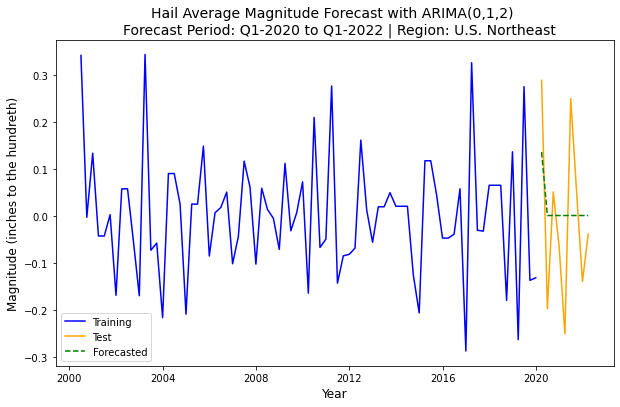

In [44]:
# Hail Average Magnitude Forecast with ARIMA(0,1,2) - Forecast Period: Q1-2020 to Q1-2022 | Region: U.S. Northeast

plt.figure(figsize=(10,6))
plt.plot(y_train.index, y_train, color='blue', label='Training')
plt.plot(y_test.index, y_test, color='orange', label='Test')
plt.plot(y_test.index, forecast, color='green', label='Forecasted', linestyle='--')

plt.title(label = 'Hail Average Magnitude Forecast with ARIMA(0,1,2) \n  Forecast Period: Q1-2020 to Q1-2022 | Region: U.S. Northeast', fontsize=14)
plt.xlabel('Year',fontsize=12)
plt.ylabel('Magnitude (inches to the hundreth)', fontsize=12)

plt.legend();

Visually, the model does not seem to have forecasted very well. While it did detect the increase in the first forecasted quarter, it started forecasting the mean right after.

### 5.5. Test Evaluation

In [47]:
r2 = r2_score(y_test, forecast)
print('R2: ' + str(r2))

R2: 0.21261139653989325


The model is able to explain 21% of the variability in the data.

In [49]:
rmse = mean_squared_error(y_test, forecast, squared=False)
print('RMSE: ' + str(rmse))

RMSE: 0.15586232674108405


In [50]:
hail.describe()

,avg_mag,first_diff
count,88.000000,88.000000
mean,0.982971,0.002826
std,0.113296,0.134673
min,0.750000,-0.286381
25%,0.914445,-0.070780
50%,0.987180,0.007749
75%,1.053592,0.063072
max,1.253509,0.344500


The RMSE of 0.16 exceeded the standard deviation of 0.13. This model's forecasts are not reliable by these evaluation metric's standards.